# Case study: Epithelial cells in different intestinal regions by 10x Chromium

This ipython notebook is part of the Molecular Systems Biology submission 'Best practices in single-cell RNA-seq analysis: a tutorial'. 

Here, a data set of different regions of the mouse intestinal epithelium from (Haber et al. 2018) is analysed using a variety of tools. This notebook is intended to illustrate a typical single-cell RNA-seq analysis pipeline using current best practices and common tools. 

The data set contains ~13,000 cells of which approximately a third come from the duodenum, the jejunum, and the ileum. These are regions of the mouse intestinal epithelium (IE). The duodenum and the jejunum are in the proximal IE, while the ileum is the distal IE. 

If the relevant libraries and modules have been installed on the system, they must be loaded. The scanpy api gives access to all tools availalbe via the scanpy platform. Numpy and scipy are useful scientific computing libraries that are used by scanpy, and pandas is used to load in the data. Pandas is also the basis of the data structures used in scanpy (the Anndata module). Matplotlib and seaborn are used for plotting.

R libraries that are used in this tutorial include:
- scran for preprocessing
- MAST for differential expression analysis
- slingshot for pseudotime and trajectory inference
- monocle2 for pseudotime and trajectory inference
- gam for finding genes that change over pseudotime
- RColorBrewer and clusterExperiment for visualization in R
- ComplexHeatmap for heatmap plotting


#### Timing
The notebook takes approximately 2 hours and 9 minutes to run on a single core with sufficient RAM. The vast majority of this time is taken up by the trajectory inference and gene expression dynamics sections, which take over 1 hour and 40 minutes. Timings of the individual sections are given in the notebook. It should be expected that timings will vary in each run.

## Table of contents:

  * <a href=#Reading>1 Reading in the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>
    * <a href=#Normalization>2.2 Normalization</a> 
    * <a href=#Batch>2.3 Batch correction</a>
    * <a href=#HVG>2.4 Highly variable genes</a>
    * <a href=#Visualization>2.5 Visualization</a>
    * <a href=#CC>2.6 Cell cycle scoring</a>
  * <a href=#Downstream>3 Downstream analysis</a>
    * <a href=#Clustering>3.1 Clustering</a>
    * <a href=#Markers>3.2 Marker genes & cluster annotation</a>
    * <a href=#Subclustering>3.3 Subclustering</a>
    * <a href=#Compositions>3.4 Compositional analysis</a>
    * <a href=#TI>3.5 Trajectory inference</a>
      * <a href=#Slingshot>3.5.1 Slingshot</a>
      * <a href=#Slingshot_nbc>3.5.2 Slingshot (w/o batch correction)</a>
      * <a href=#Monocle>3.5.3 Monocle</a>
      * <a href=#DPT>3.5.4 Diffusion Pseudotime</a>
    * <a href=#Gene_dynamics>3.6 Gene expression dynamics</a>
    * <a href=#Metastable>3.7 Metastable states</a>
    * <a href=#PAGA>3.8 Partition-based graph abstraction</a>
    * <a href=#Gene-level>3.9 Gene-level analysis</a>
      * <a href=#Diff_expr>3.9.1 Differential expression</a>
      * <a href=#Gene_set>3.9.2 Gene set analysis</a>
    * <a href=#Write>3.10 Writing to file</a>
  * <a href=#Summary>4 Summary</a>
    * <a href=#Comparison>4.1 Comparison with published results</a>

# 0. Loading the libraries

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%reload_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.3+115.g1aecabf anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

<a id="Reading"></a>

# 1. Reading in the data

The Haber et al. data set was retrieved from the Gene Expression Omnibus (GEO) via the ID GSE92332. The regional single cell expression data sets were extracted from the GSE92332_RAW.tar file (https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE92332&format=file) and are loaded by scanpy's read function. Note that single cell data exists in many formats and loading data may therefore require preprocessing. Packages like Scanpy and Seurat facilitate the data loading process by supporting several sparse and dense data formats in their read functions. When adapting the tutorial code to your own dataset, you will likely have to make changes to this section to match to the format of your data.

Here, we are reading in sparse count matrices, but are immediately converting these to dense representation with the .toarray() function. We create dense matrices as our batch correction method outputs a dense expression matrix, and the data transfer between R and python is currently limited to dense matrices. When sparse batch correction methods are available, and rpy2 is extended to sparse matrices, it is more memory-efficient to keep the data in a sparse format.

It should also be noted that the conventions for storing single cell data differ between R (Seurat, or Scater) and python platforms (Scanpy). Scanpy expects the data to be stored in the format cells x genes, while R platforms expect the transpose. As data is typically stored in the format genes x cells in the GEO, we must transpose the data before using it.

Finally, the `Macosko_cell_cycle_genes.txt` contains a list of marker genes for different cell cycle phases. It can be ignored for now. We come back to this file in the <a href=#CC>Cell cycle scoring</a> section.

[Timing: 18.7s reading from cache]

In [4]:
# Set up data loading

#Data files
sample_strings = ['Duo_M1', 'Duo_M2', 'Jej_M1', 'Jej_M2', 'Il_M1', 'Il_M2']
sample_id_strings = ['3', '4', '5', '6', '7', '8']
file_base = '../data/Haber-et-al_mouse-intestinal-epithelium/GSE92332_RAW/GSM283657'
exp_string = '_Regional_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
cc_genes_file = '../Macosko_cell_cycle_genes.txt'

In [5]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
sample_id = sample_id_strings.pop(0)
data_file = file_base+sample_id+exp_string+sample+data_file_end
barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
gene_file = file_base+sample_id+exp_string+sample+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
print([sample])
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['region'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['donor'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
print(adata.obs)

... reading from cache file cache/..-data-Haber-et-al_mouse-intestinal-epithelium-GSE92332_RAW-GSM2836573_Regional_Duo_M1_matrix.h5ad
['Duo_M1']
                  sample region donor
barcode                              
AAACATACAGCGGA-1  Duo_M1    Duo    M1
AAACATACCTTACT-1  Duo_M1    Duo    M1
AAACATACTTTGCT-1  Duo_M1    Duo    M1
AAACCGTGCAGTCA-1  Duo_M1    Duo    M1
AAACGCTGCAGTCA-1  Duo_M1    Duo    M1
AAACGCTGCGTGAT-1  Duo_M1    Duo    M1
AAACGCTGTCCAGA-1  Duo_M1    Duo    M1
AAACGCTGTTCACT-1  Duo_M1    Duo    M1
AAACGGCTACACTG-1  Duo_M1    Duo    M1
AAACGGCTCAACCA-1  Duo_M1    Duo    M1
AAACGGCTCTAAGC-1  Duo_M1    Duo    M1
AAACGGCTGTTGCA-1  Duo_M1    Duo    M1
AAAGACGAACGTTG-1  Duo_M1    Duo    M1
AAAGAGACGGCATT-1  Duo_M1    Duo    M1
AAAGATCTTAACGC-1  Duo_M1    Duo    M1
AAAGCAGAACGCAT-1  Duo_M1    Duo    M1
AAAGCAGAGCGTTA-1  Duo_M1    Duo    M1
AAAGGCCTGAGGCA-1  Duo_M1    Duo    M1
AAAGGCCTGGAACG-1  Duo_M1    Duo    M1
AAAGTTTGCCATAG-1  Duo_M1    Duo    M1
AAATACTGCGTACA-1  D

In [6]:
print(adata.obs['sample'])

barcode
AAACATACAGCGGA-1    Duo_M1
AAACATACCTTACT-1    Duo_M1
AAACATACTTTGCT-1    Duo_M1
AAACCGTGCAGTCA-1    Duo_M1
AAACGCTGCAGTCA-1    Duo_M1
AAACGCTGCGTGAT-1    Duo_M1
AAACGCTGTCCAGA-1    Duo_M1
AAACGCTGTTCACT-1    Duo_M1
AAACGGCTACACTG-1    Duo_M1
AAACGGCTCAACCA-1    Duo_M1
AAACGGCTCTAAGC-1    Duo_M1
AAACGGCTGTTGCA-1    Duo_M1
AAAGACGAACGTTG-1    Duo_M1
AAAGAGACGGCATT-1    Duo_M1
AAAGATCTTAACGC-1    Duo_M1
AAAGCAGAACGCAT-1    Duo_M1
AAAGCAGAGCGTTA-1    Duo_M1
AAAGGCCTGAGGCA-1    Duo_M1
AAAGGCCTGGAACG-1    Duo_M1
AAAGTTTGCCATAG-1    Duo_M1
AAATACTGCGTACA-1    Duo_M1
AAATACTGGGTGAG-1    Duo_M1
AAATCCCTAAGCCT-1    Duo_M1
AAATCTGAACGGGA-1    Duo_M1
AAATCTGACGGAGA-1    Duo_M1
AAATTCGATCGTAG-1    Duo_M1
AAATTCGATTATCC-1    Duo_M1
AAATTGACATCGTG-1    Duo_M1
AACAATACAGGCGA-1    Duo_M1
AACAATACCTGAAC-1    Duo_M1
                     ...  
TTGATCTGGCAAGG-1    Duo_M1
TTGATCTGGTGCAT-1    Duo_M1
TTGCATTGCCTACC-1    Duo_M1
TTGCATTGGTTCTT-1    Duo_M1
TTGCTATGTTCTGT-1    Duo_M1
TTGGAGACGGTACT-1    

In [7]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    sample_id = sample_id_strings[i]
    data_file = file_base+sample_id+exp_string+sample+data_file_end
    barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
    gene_file = file_base+sample_id+exp_string+sample+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['region'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['donor'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample_id')
    #adata.var['gene_id'] = adata.var['gene_id-1']
    #adata.var.drop(columns = ['gene_id-1', 'gene_id-0'], inplace=True)
    adata.obs.drop(columns=['sample_id'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')
print(adata.obs['sample'])

... reading from cache file cache/..-data-Haber-et-al_mouse-intestinal-epithelium-GSE92332_RAW-GSM2836574_Regional_Duo_M2_matrix.h5ad


Making variable names unique for controlled concatenation.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-Haber-et-al_mouse-intestinal-epithelium-GSE92332_RAW-GSM2836575_Regional_Jej_M1_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-Haber-et-al_mouse-intestinal-epithelium-GSE92332_RAW-GSM2836576_Regional_Jej_M2_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-Haber-et-al_mouse-intestinal-epithelium-GSE92332_RAW-GSM2836577_Regional_Il_M1_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-Haber-et-al_mouse-intestinal-epithelium-GSE92332_RAW-GSM2836578_Regional_Il_M2_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AAACATACAGCGGA      Duo_M1
AAACATACCTTACT      Duo_M1
AAACATACTTTGCT      Duo_M1
AAACCGTGCAGTCA      Duo_M1
AAACGCTGCAGTCA      Duo_M1
AAACGCTGCGTGAT      Duo_M1
AAACGCTGTCCAGA      Duo_M1
AAACGCTGTTCACT      Duo_M1
AAACGGCTACACTG      Duo_M1
AAACGGCTCAACCA      Duo_M1
AAACGGCTCTAAGC      Duo_M1
AAACGGCTGTTGCA      Duo_M1
AAAGACGAACGTTG      Duo_M1
AAAGAGACGGCATT      Duo_M1
AAAGATCTTAACGC      Duo_M1
AAAGCAGAACGCAT      Duo_M1
AAAGCAGAGCGTTA      Duo_M1
AAAGGCCTGAGGCA      Duo_M1
AAAGGCCTGGAACG      Duo_M1
AAAGTTTGCCATAG      Duo_M1
AAATACTGCGTACA      Duo_M1
AAATACTGGGTGAG      Duo_M1
AAATCCCTAAGCCT      Duo_M1
AAATCTGAACGGGA      Duo_M1
AAATCTGACGGAGA      Duo_M1
AAATTCGATCGTAG      Duo_M1
AAATTCGATTATCC      Duo_M1
AAATTGACATCGTG      Duo_M1
AACAATACAGGCGA      Duo_M1
AACAATACCTGAAC      Duo_M1
                     ...  
TTGAGGTGCTCCCA       Il_M2
TTGATCTGAGACTC       Il_M2
TTGCATTGGGTGAG_1     Il_M2
TTGCTAACAAGGCG       Il_M2
TTGCTAACGCCCTT       Il_M2
TTGCTATGATGCCA       Il_M2
T

Note that this next line just cleans up the variable names which are stored as `mm10_` + MGI gene symbol in this dataset.

In [8]:
#Assign variable names and gene id columns
#adata.var_names = [g.split("_")[1] for g in adata.var_names]
#adata.var['gene_id'] = [g.split("_")[1] for g in adata.var['gene_id']]
print(adata.var['gene_id'])
print(adata)

mm10_Xkr4              mm10_ENSMUSG00000051951
mm10_Gm1992            mm10_ENSMUSG00000089699
mm10_Gm37381           mm10_ENSMUSG00000102343
mm10_Rp1               mm10_ENSMUSG00000025900
mm10_Rp1-1             mm10_ENSMUSG00000109048
mm10_Sox17             mm10_ENSMUSG00000025902
mm10_Gm37323           mm10_ENSMUSG00000104328
mm10_Mrpl15            mm10_ENSMUSG00000033845
mm10_Lypla1            mm10_ENSMUSG00000025903
mm10_Gm37988           mm10_ENSMUSG00000104217
mm10_Tcea1             mm10_ENSMUSG00000033813
mm10_Rgs20             mm10_ENSMUSG00000002459
mm10_Gm16041           mm10_ENSMUSG00000085623
mm10_Atp6v1h           mm10_ENSMUSG00000033793
mm10_Oprk1             mm10_ENSMUSG00000025905
mm10_Npbwr1            mm10_ENSMUSG00000033774
mm10_Rb1cc1            mm10_ENSMUSG00000025907
mm10_4732440D04Rik     mm10_ENSMUSG00000090031
mm10_Fam150a           mm10_ENSMUSG00000087247
mm10_St18              mm10_ENSMUSG00000033740
mm10_Pcmtd1            mm10_ENSMUSG00000051285
mm10_Gm26901 

Once the data is read in and annotated, we test whether we have the expected number of cells for each region, mouse (donor), and sample.

In [9]:
# Annotate the data sets
print(adata.obs['region'].value_counts())
print('')
print(adata.obs['donor'].value_counts())
print('')
print(adata.obs['sample'].value_counts())
print(adata.obs)

Duo    4554
Jej    4496
Il     4303
Name: region, dtype: int64

M2    6711
M1    6642
Name: donor, dtype: int64

Jej_M2    2668
Il_M1     2466
Duo_M1    2348
Duo_M2    2206
Il_M2     1837
Jej_M1    1828
Name: sample, dtype: int64
                 donor region  sample
AAACATACAGCGGA      M1    Duo  Duo_M1
AAACATACCTTACT      M1    Duo  Duo_M1
AAACATACTTTGCT      M1    Duo  Duo_M1
AAACCGTGCAGTCA      M1    Duo  Duo_M1
AAACGCTGCAGTCA      M1    Duo  Duo_M1
AAACGCTGCGTGAT      M1    Duo  Duo_M1
AAACGCTGTCCAGA      M1    Duo  Duo_M1
AAACGCTGTTCACT      M1    Duo  Duo_M1
AAACGGCTACACTG      M1    Duo  Duo_M1
AAACGGCTCAACCA      M1    Duo  Duo_M1
AAACGGCTCTAAGC      M1    Duo  Duo_M1
AAACGGCTGTTGCA      M1    Duo  Duo_M1
AAAGACGAACGTTG      M1    Duo  Duo_M1
AAAGAGACGGCATT      M1    Duo  Duo_M1
AAAGATCTTAACGC      M1    Duo  Duo_M1
AAAGCAGAACGCAT      M1    Duo  Duo_M1
AAAGCAGAGCGTTA      M1    Duo  Duo_M1
AAAGGCCTGAGGCA      M1    Duo  Duo_M1
AAAGGCCTGGAACG      M1    Duo  Duo_M1
AAAGTTTGCC

We have 4554, 4496, and 4303 cells from the Duodenum, Jejunum, and Ileum respectively.

In [10]:
# Checking the total size of the data set
adata.shape

(13353, 27998)

We have 13,353 cells and 27,998 genes in the dataset.

<a id="Preprocessing"></a>

# 2 Pre-processing and visualization

<a id="QC"></a>

## 2.1 Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

[Timing: 39.9s]

In [11]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

... storing 'donor' as categorical
... storing 'region' as categorical
... storing 'sample' as categorical


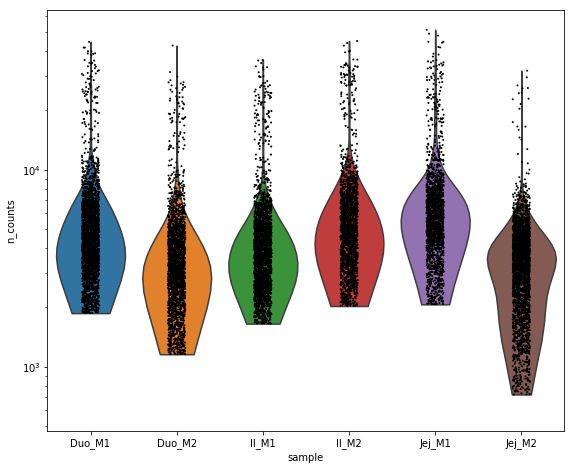

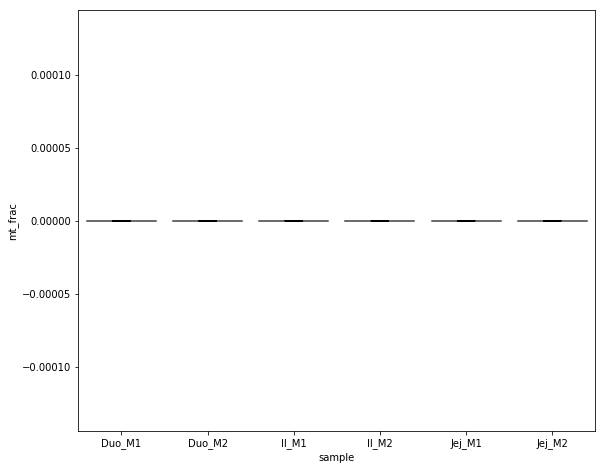

In [12]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample')

The plots show that the Jej_M2 sample has the poorest quality in comparison. The counts per cell are still sufficiently high to process these cells, and the fraction of mitochondrial reads (MT frac) for most cells are still far below 20-25%, which are the typical filtering thresholds.

We could perform QC filtering per sample here to address this issue, yet the mode of the distributions look similar to other samples (e.g., 'Il_M1'). It may be worth keeping in mind that one sample has a few poorer quality cells though.

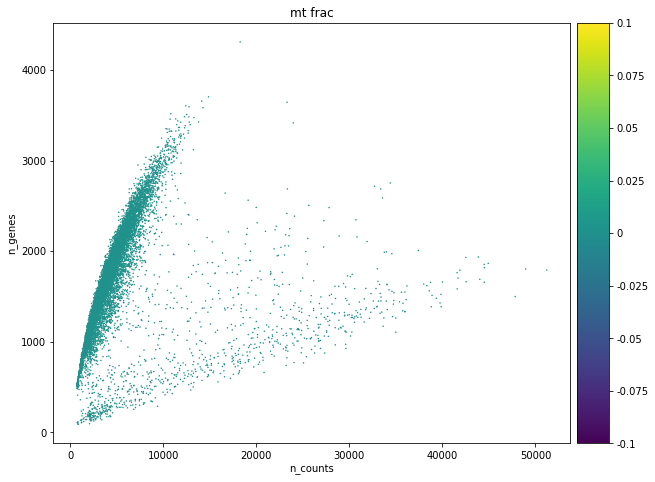

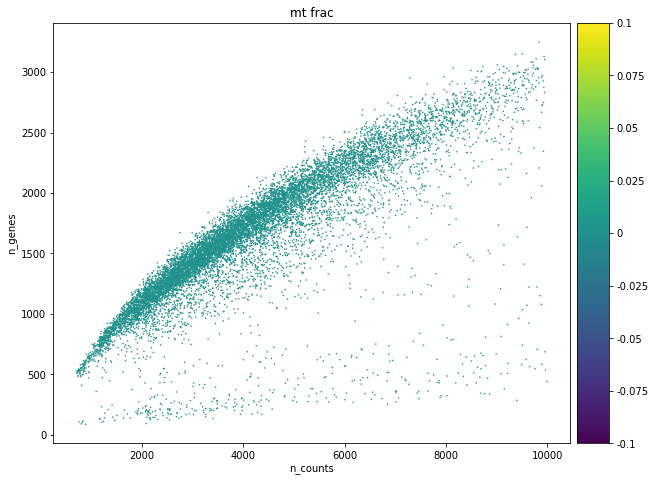

In [13]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there are cells with unexpected summary statistics. It is important here to look at these statistics jointly. For example, there is a cloud of points with many counts, but few genes. Our first instinct would be to filter out these as "dying" outliers, however they don't seem to show high MT fraction. We should probably still filter out some cells with very few genes as these may be difficult to annotate later. This will be true for the initial cellular density between 1000-4000 counts and < ~500 genes.

Furthermore it can be seen in the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

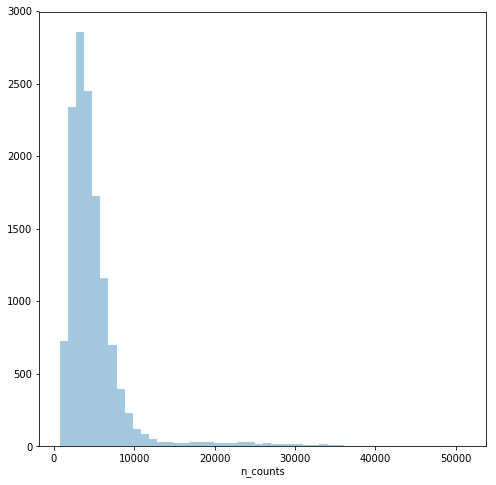

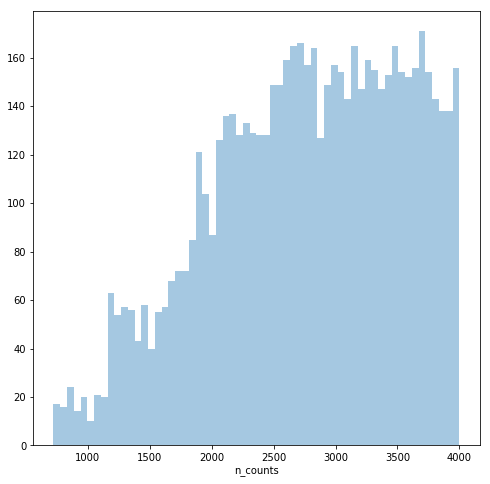

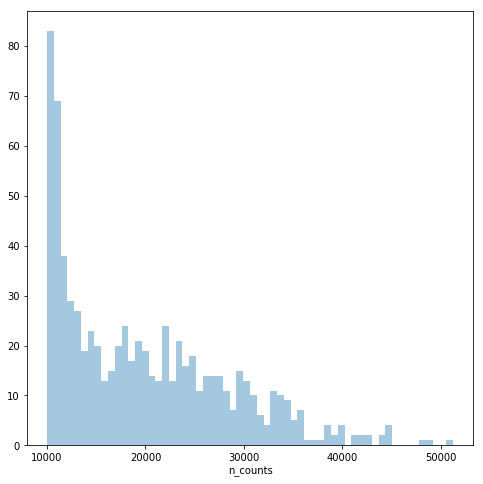

In [14]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

Histograms of the number of counts per cell show that there are two small peaks of groups of cells with fewer than 1500 counts. which are likely uninformative given the overall distribution of counts. This may be cellular debris found in droplets.

On the upper end of counts, we see a population of cells with high counts shown as a broad peak at 20,000 counts. We estimate this population to range until 40,000 counts. This estimation is performed by visually tracing a Gaussian around the population.

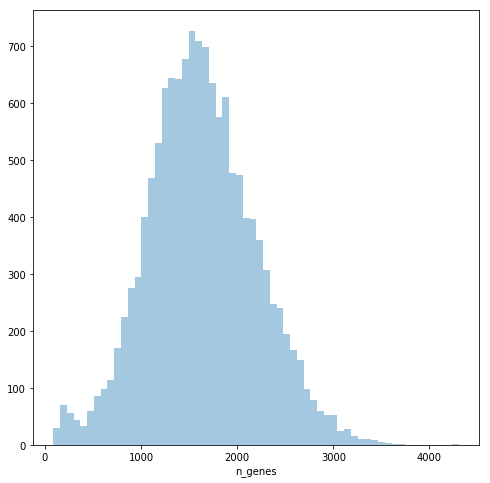

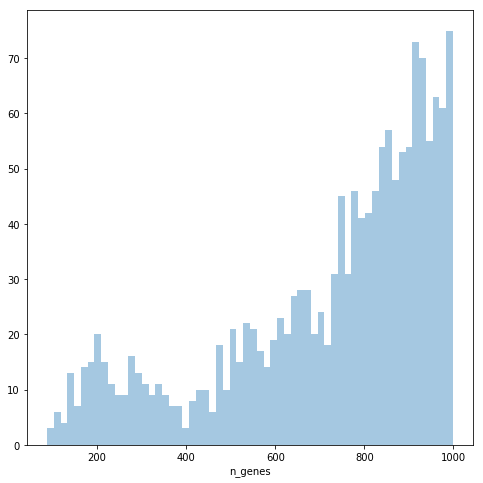

In [15]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()


Two populations of cells with low gene counts can be seen in the above plots. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 700 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold.

In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

In [16]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))




Total number of cells: 13353
filtered out 479 cells that haveless than 1500 counts
Number of cells after min count filter: 12874
filtered out 16 cells that havemore than 40000 counts
Number of cells after max count filter: 12858
Number of cells after MT filter: 12858
filtered out 401 cells that haveless than 700 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 12457


In [17]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 15180 genes that are detectedin less than 20 cells
Number of genes after cell filter: 12818


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 

<a id="Normalization"></a>

## 2.2 Normalization

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Based on comparisons of normalization methods for differential testing (personal communication from Beathe Vieth), and batch correction [Buettner et al., 2019], the normalization method implemented in the scran package performs best. This method requires a coarse clustering input to improve size factor esimation performance. Thus, we use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.

[Timing: 2min 46.73s; 2min 22s of which in scran R code]

In [18]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDi

    finished (0:00:14)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02)


In [19]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [20]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [21]:
#Delete adata_pp
del adata_pp

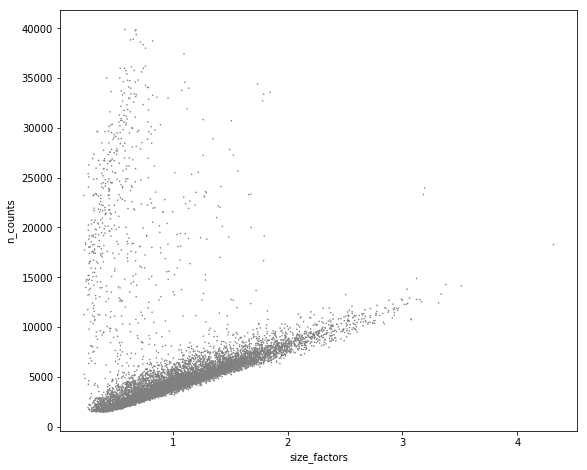

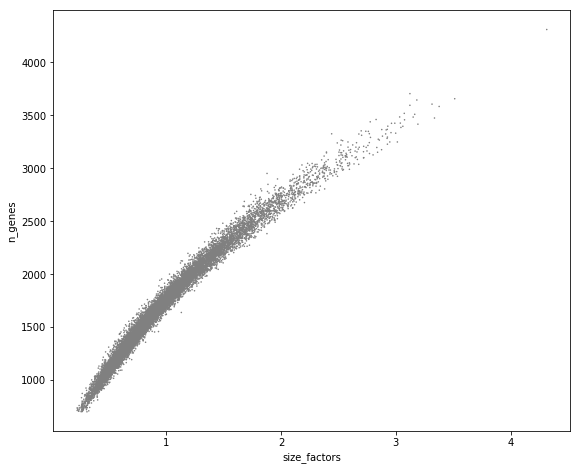

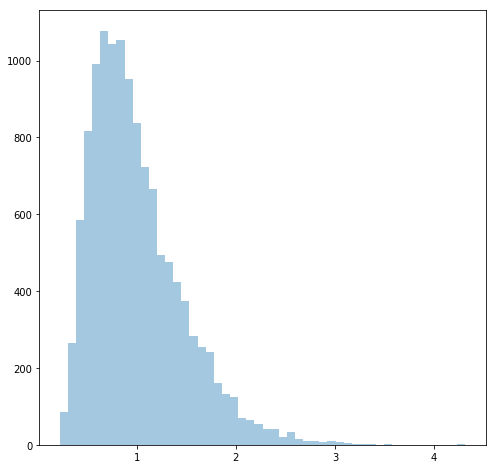

In [22]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

We plot the size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

Before normalizing the data, we ensure that a copy of the raw count data is kept in a separate AnnData object. This allows us to use methods downstream that require this data as input.

In [23]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [24]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [25]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

The count data has been normalized and log-transformed with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

<a id="Batch"></a>

## 2.3 Batch Correction

Batch correction is performed to adjust for batch effects from the 6 samples that were loaded. As the batch effect from samples and from epithelium regions are overlapping, correcting for this batch effect will also partially regress out differences between regions. We allow for this to optimally cluster the data. This approach can also be helpful to find differentiation trajectories, but we revert back to non-batch-corrected data for differential testing and computing marker genes.

Note that ComBat batch correction requires a dense matrix format as input (which is already the case in this example).

[Timing: 1min 34s]

In [26]:
# ComBat batch correction
sc.pp.combat(adata, key='sample')

Standardizing Data across genes.

Found 6 batches

Found 0 numerical variables:
	



MemoryError: 

Note ComBat batch correction can produce negative expression values. One can either set all negative values to 0 or force zeros pre-batch-correction to remain zero post-batch-correction. For simplicity we opt not to do this here.

<a id="HVG"></a>

## 2.4 Highly Variable Genes

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software CellRanger. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

[Timing: 6.61s]

In [ ]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

In [ ]:
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the adata.var['highly_variable'] field. The dataset now contains:
- a 'counts' layer with count data
- log-normalized data in adata.raw
- batch corrected data in adata.X
- highly variable gene annotations in adata.var['highly_variable']

The HVG labels will be used to subselect genes for clustering and trajectory analysis.

<a id="Visualization"></a>

## 2.5 Visualization

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. 

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

Note that we do not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). We argue that this weighting based on mean expression being a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.

[Timing: 6min 54s; 03min 46s of which are spent on t-SNE calculation, and 2min 7s on draw_graph]

In [ ]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

In [ ]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.tsne(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

PCA:
- Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
- The plot does not show the expected clustering of the data in two dimensions

t-SNE:
- Shows several distinct clusters with clear subcluster structure
- Connections between clusters are difficult to interpret visually

UMAP:
- Data points are spread out on the plot showing several clusters
- Connections between clusters can be readily identified

Diffusion Maps:
- Shows connections between regions of higher density
- Very clear trajectories are suggested, but clusters are less clear
- Each diffusion component extracts heterogeneity in a different part of the data

Graph:
- Shows a central cluster and several outer clusters
- Shows clear connections from the central cluster (likely stem cells) to outer clusters

The strengths and weaknesses of the visualizations can readily be identified in the above plots. While t-SNE exaggerates differences, diffusion maps exaggerate transitions. Overall UMAP and force-directed graph drawings show the best compromise of the two aspects, however UMAP is much faster to compute (8s vs 114s here). UMAP has furthermore been shown to more accurately display the structure in the data.

<a id="CC"></a>

## 2.6 Cell cycle scoring

Known sources of technical variation in the data have been investigated and corrected for (e.g. batch, count depth). A known source of biological variation that can explain the data is the cell cycle. Here, a gene list from Macosko et al., Cell 161 (2015) is used to score the cell cycle effect in the data and classify cells by cell cycle phase. The file can be found on the single-cell-tutorial github repository, or be taken from the supplementary material of the paper.

Please note, that s the gene list was generated for human HeLa cells, the gene names are put into lower case with a leading capital letter to map to the respective mouse genes. When adapting this script to your own data, this must be taken into account for data from species other than mouse.

We perform cell cycle scoring on the full batch-corrected data set in adata.

[Timing: 10.7s]

In [ ]:
#Score cell cycle and visualize the effect:
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, s_genes_mm)]
g2m_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)

In [ ]:
sc.pl.umap(adata, color=['S_score', 'G2M_score'], use_raw=False)
sc.pl.umap(adata, color='phase', use_raw=False)

Cell cycle scoring shows a pronounced proliferation signal in the largest central cluster in the Umap representation. This suggests a proliferation phenotype in these cells. Other clusters also show less pronouced cell cycle structure.

<a id="Downstream"></a>

# 3 Downstream analysis

<a id="Clustering"></a>

## 3.1 Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see `sc.pp.pca()` and `sc.pp.neighbors()` functions used in the visualization section.

[Timing: 8.08s]

Update notice (24.06.2019):

Modularity optimization via louvain has a stochastic element to it. This stochasticity typically does not affect the biological interpretation of the data, but can change the details of analysis scripts. Normally scanpy fixes the random seed to 0 to make scripts exactly reproducible. 

In our latest update, we have used a random seed of 10 as this best reproduced the clustering in the previous notebook with the default random seed of 0. This is purely done for consistency between versions. The best approach would of course be a consensus clustering across many random seeds. This is left for a future update.

In [ ]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

In [ ]:
adata.obs['louvain_r0.5'].value_counts()

In [ ]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['region', 'n_counts'])
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

At a resolution of 0.5 the broad clusters in the visualization are captured well in the data. The covariate plots show that clusters 0 and 6 in this data set are characterized by low and high counts respectively. In the case of cluster 6 this may be biologically relevant, while cluster 0 is also characterized by higher mitochondrial read fractions. This indicates cell stress.

The variation captured by the clustering is not related to the intestinal epithelium regions. This suggests we are detecting cell types across regions as intended.

<a id="Markers"></a>

## 3.2 Marker genes & cluster annotation

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a Welch t-test with overestimated variance to be conservative. This is the default in scanpy. The test is automatically performed on the `.raw` data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

As we are using the relevant mouse gut atlas from the literature in this case study, there is no other reference atlas which we use to annotate the cells by automated annotation. Thus, we do not use scmap or garnett here.

[Timing: 25.1s]

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['0','1','2'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['3','4','5'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['6', '7', '8'], fontsize=12)

First inspection of the marker gene plots shows that cluster 4 is indeed characterized by high expression of mitochondrial genes. Together with the low counts this suggests a 'stressed' phenotype.

To further identify the clusters in our data set, we look at the overlap with a list of known marker genes. Here, these marker genes were taken from the publication from which the data was obtained (Haber et al, 2018). 

In practice marker gene sets can be obtained from public databases such as Linnarson's mouse brain atlas, various Human Cell Atlas datasets, and other published reference atlases. It should be noted that marker genes may not always overlap as expected given that atlases tend to be investigated under wild-type conditions.

In [ ]:
#Known marker genes:
marker_genes = dict()
marker_genes['Stem'] = ['Lgr5', 'Ascl2', 'Slc12a2', 'Axin2', 'Olfm4', 'Gkn3']
marker_genes['Enterocyte (Proximal)'] = ['Gsta1','Rbp2','Adh6a','Apoa4','Reg3a','Creb3l3','Cyp3a13','Cyp2d26','Ms4a10','Ace','Aldh1a1','Rdh7','H2-Q2', 'Hsd17b6','Gstm3','Gda','Apoc3','Gpd1','Fabp1','Slc5a1','Mme','Cox7a1','Gsta4','Lct','Khk','Mttp','Xdh','Sult1b1', 'Treh','Lpgat1','Dhrs1','Cyp2c66','Ephx2','Cyp2c65','Cyp3a25','Slc2a2','Ugdh','Gstm6','Retsat','Ppap2a','Acsl5', 'Cyb5r3','Cyb5b','Ckmt1','Aldob','Ckb','Scp2','Prap1']
marker_genes['Enterocyte (Distal)'] = ['Tmigd1','Fabp6','Slc51b','Slc51a','Mep1a','Fam151a','Naaladl1','Slc34a2','Plb1','Nudt4','Dpep1','Pmp22','Xpnpep2','Muc3','Neu1','Clec2h','Phgr1','2200002D01Rik','Prss30','Cubn','Plec','Fgf15','Crip1','Krt20','Dhcr24','Myo15b','Amn','Enpep','Anpep','Slc7a9','Ocm','Anxa2','Aoc1','Ceacam20','Arf6','Abcb1a','Xpnpep1','Vnn1','Cndp2','Nostrin','Slc13a1','Aspa','Maf','Myh14']
marker_genes['Goblet'] = ['Agr2', 'Fcgbp', 'Tff3', 'Clca1', 'Zg16', 'Tpsg1', 'Muc2', 'Galnt12', 'Atoh1', 'Rep15', 'S100a6', 'Pdia5', 'Klk1', 'Pla2g10', 'Spdef', 'Lrrc26', 'Ccl9', 'Bace2', 'Bcas1', 'Slc12a8', 'Smim14', 'Tspan13', 'Txndc5', 'Creb3l4', 'C1galt1c1', 'Creb3l1', 'Qsox1', 'Guca2a', 'Scin', 'Ern2', 'AW112010', 'Fkbp11', 'Capn9', 'Stard3nl', 'Slc50a1', 'Sdf2l1', 'Hgfa', 'Galnt7', 'Hpd', 'Ttc39a', 'Tmed3', 'Pdia6', 'Uap1', 'Gcnt3', 'Tnfaip8', 'Dnajc10', 'Ergic1', 'Tsta3', 'Kdelr3', 'Foxa3', 'Tpd52', 'Tmed9', 'Spink4', 'Nans', 'Cmtm7', 'Creld2', 'Tm9sf3', 'Wars', 'Smim6', 'Manf', 'Oit1', 'Tram1', 'Kdelr2', 'Xbp1', 'Serp1', 'Vimp', 'Guk1', 'Sh3bgrl3', 'Cmpk1', 'Tmsb10', 'Dap', 'Ostc', 'Ssr4', 'Sec61b', 'Pdia3', 'Gale', 'Klf4', 'Krtcap2', 'Arf4', 'Sep15', 'Ssr2', 'Ramp1', 'Calr', 'Ddost']
marker_genes['Paneth'] = ['Gm15284', 'AY761184', 'Defa17', 'Gm14851', 'Defa22', 'Defa-rs1', 'Defa3', 'Defa24', 'Defa26', 'Defa21', 'Lyz1', 'Gm15292', 'Mptx2', 'Ang4']
marker_genes['Enteroendocrine'] = ['Chgb', 'Gfra3', 'Cck', 'Vwa5b2', 'Neurod1', 'Fev', 'Aplp1', 'Scgn', 'Neurog3', 'Resp18', 'Trp53i11', 'Bex2', 'Rph3al', 'Scg5', 'Pcsk1', 'Isl1', 'Maged1', 'Fabp5', 'Celf3', 'Pcsk1n', 'Fam183b', 'Prnp', 'Tac1', 'Gpx3', 'Cplx2', 'Nkx2-2', 'Olfm1', 'Vim', 'Rimbp2', 'Anxa6', 'Scg3', 'Ngfrap1', 'Insm1', 'Gng4', 'Pax6', 'Cnot6l', 'Cacna2d1', 'Tox3', 'Slc39a2', 'Riiad1']
marker_genes['Tuft'] = ['Alox5ap', 'Lrmp', 'Hck', 'Avil', 'Rgs13', 'Ltc4s', 'Trpm5', 'Dclk1', 'Spib', 'Fyb', 'Ptpn6', 'Matk', 'Snrnp25', 'Sh2d7', 'Ly6g6f', 'Kctd12', '1810046K07Rik', 'Hpgds', 'Tuba1a', 'Pik3r5', 'Vav1', 'Tspan6', 'Skap2', 'Pygl', 'Ccdc109b', 'Ccdc28b', 'Plcg2', 'Ly6g6d', 'Alox5', 'Pou2f3', 'Gng13', 'Bmx', 'Ptpn18', 'Nebl', 'Limd2', 'Pea15a', 'Tmem176a', 'Smpx', 'Itpr2', 'Il13ra1', 'Siglecf', 'Ffar3', 'Rac2', 'Hmx2', 'Bpgm', 'Inpp5j', 'Ptgs1', 'Aldh2', 'Pik3cg', 'Cd24a', 'Ethe1', 'Inpp5d', 'Krt23', 'Gprc5c', 'Reep5', 'Csk', 'Bcl2l14', 'Tmem141', 'Coprs', 'Tmem176b', '1110007C09Rik', 'Ildr1', 'Galk1', 'Zfp428', 'Rgs2', 'Inpp5b', 'Gnai2', 'Pla2g4a', 'Acot7', 'Rbm38', 'Gga2', 'Myo1b', 'Adh1', 'Bub3', 'Sec14l1', 'Asah1', 'Ppp3ca', 'Agt', 'Gimap1', 'Krt18', 'Pim3', '2210016L21Rik', 'Tmem9', 'Lima1', 'Fam221a', 'Nt5c3', 'Atp2a3', 'Mlip', 'Vdac3', 'Ccdc23', 'Tmem45b', 'Cd47', 'Lect2', 'Pla2g16', 'Mocs2', 'Arpc5', 'Ndufaf3']

In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.5')
cell_annotation

We can also visualize the marker gene overlap as a fraction of the total marker genes, and then plot this as a heatmap for simpler cell identity annotation.

In [ ]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

Here we look simply at the fraction of known marker genes that are found in the cluster marker gene sets from the rank_genes_groups() function. This allows us to clearly identify tuft cells, enteroendocrine cells, paneth cells, enterocytes, and stem cells.

A more rigorous analysis would be to perform an enrichment test. Yet, in this data set the assignment is sufficiently clear so that it is not necessary.

As we see quite an overlap of Goblet markers in cluster 6, which otherwise seems to contain paneth cells, we will visualize the expression of two markers to show the respective populations.

Note that `use_raw=False` is used to visualize batch-corrected data on top of the UMAP layout.

In [ ]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [ ]:
#Defa24 #Tff3
sc.pl.umap(adata, color='Defa24', use_raw=False, color_map=mymap)
sc.pl.umap(adata, color='Tff3', use_raw=False, color_map=mymap)


It is evident that the two clusters are distinct, yet goblet cell markers may also be expressed in paneth cells at a lower level.

To identify clusters 0, 1, and 4, we now look at known marker gene expression. It is possible that a known marker is expressed in a cluster although it is not a marker gene for this cluster given its expression in another cluster is higher. This can be the case especially for progenitor cells. We visualize gene expression on the full, batch-corrected data set in adata.

Given the position of clusters 0, 1, and 4 in the UMAP visualization enterocyte and stem cell markers are of particular interest.

In [ ]:
# Check expression of enterocyte markers
#Collate all enterocyte markers and get the gene IDs in the data set
ids_entprox = np.in1d(adata.var_names, marker_genes['Enterocyte (Proximal)'])
ids_entdist = np.in1d(adata.var_names, marker_genes['Enterocyte (Distal)'])
ids_ent = np.logical_or(ids_entprox, ids_entdist)

#Calculate the mean expression of enterocyte markers
adata.obs['Enterocyte_marker_expr'] = adata.X[:,ids_ent].mean(1)

#Plot enterocyte expression
sc.pl.violin(adata, 'Enterocyte_marker_expr', groupby='louvain_r0.5')
sc.pl.umap(adata, color='Enterocyte_marker_expr', color_map=mymap)


In [ ]:
#Early enterocyte marker - Arg2
sc.pl.umap(adata, color='Arg2', use_raw=False, color_map=mymap)

sc.pl.violin(adata, groupby='louvain_r0.5', keys='Arg2', use_raw=False)

sc.pl.diffmap(adata, components=['6,9'], color='Arg2', use_raw=False, color_map=mymap)
sc.pl.diffmap(adata, components=['6,9'], color='louvain_r0.5')

The violin plots show that enterocyte marker expression is slightly higher in clusters 1 and 4 compared to other clusters except for the enterocyte cluster 5. For cluster 4 this is particular noticeable in Arg2 expression, which is an enterocyte marker that can already be measured at early stages of differentiation.

The diffusion map with Arg2 expression visualized confirms that clusters 1 and 4 are between stem cells and enterocytes and are positioned where Arg2 expression is present. Cluster 0, on the other hand seems to be a little separated from the enterocyte trajectory.

In [ ]:
sc.pl.violin(adata, 'mt_frac', groupby='louvain_r0.5')
sc.pl.violin(adata, 'log_counts', groupby='louvain_r0.5')

We looked at technical covariates to confirm the 'stressed' phenotype of cluster 4 to differentiate clusters 1 and 4.

In [ ]:
#Check individual stem markers
stem_genes = adata.var_names[np.in1d(adata.var_names, marker_genes['Stem'])]
sc.pl.umap(adata, color=stem_genes[:3], title=stem_genes[:3], color_map=mymap)
sc.pl.umap(adata, color=stem_genes[3:], title=stem_genes[3:], color_map=mymap)

In [ ]:
#Check stem marker expression
adata.obs['Stem_marker_expr'] = adata[:,stem_genes].X.mean(1)

sc.pl.violin(adata, 'Stem_marker_expr', groupby='louvain_r0.5')
sc.pl.umap(adata, color='Stem_marker_expr', color_map=mymap)


Clusters 0 and 1 show more stem-like expression patterns compared to clusters 4. Together with the cell-cycle signature seen in a previous plot, cluster 0 shows a proliferative signature, and thus points towards transit amplifying cells. 

Clusters 1 and 4 have heightened enterocyte markers, but are more stem-like than enterocytes. They likely consist of enterocyte progenitors (EPs).

Cluster 1 appears to represent an earlier stage of EP than cluster 4 given the diffusion map, and the enterocyte marker expression levels. It may consist of a mixture of Stem cells and EPs.

The identified cell types are renamed in the full data set.

In [ ]:
#Categories to rename
adata.obs['louvain_r0.5'].cat.categories

In [ ]:
adata.rename_categories('louvain_r0.5', ['TA', 'EP (early)', 'Stem', 'Goblet', 'EP (stress)', 'Enterocyte', 'Paneth', 'Enteroendocrine', 'Tuft'])

In [ ]:
adata.obs['louvain_r0.5'].value_counts()

In [ ]:
sc.pl.umap(adata, color='louvain_r0.5', size=15, legend_loc='on data')

<a id="Subclustering"></a>

## 3.3 Subclustering

To build on the basis clustering, we can now subcluster parts of the data to identify substructure within the identified cell types. Here, we subcluster the 'Enterocyte' population to see if we can find distal and proximal enterocyte clusters which were obtained in the (Haber et al. 2018) paper.

Subclustering is normally performed at a lower resolution than on the entire dataset given that clustering is more sensitive when performed on a small subset of the data.

[Timing: 57.2s]

In [ ]:
#Subcluster enterocytes
sc.tl.louvain(adata, restrict_to=('louvain_r0.5', ['Enterocyte']), resolution=0.2, key_added='louvain_r0.5_entero_sub')

In [ ]:
#Show the new clustering
if 'louvain_r0.5_entero_sub_colors' in adata.uns:
    del adata.uns['louvain_r0.5_entero_sub_colors']

sc.pl.umap(adata, color='louvain_r0.5_entero_sub', palette=sc.pl.palettes.godsnot_64)
sc.pl.umap(adata, color='region', palette=sc.pl.palettes.godsnot_64)

The subclustering has identified four subclusters of enterocytes. Plots of the the intestinal regions show that proximal (duodenum and jejunum) and distal (ileum) enterocytes have been separated in some clusters.

Marker genes are now computed to verify this observation quantitatively.

In [ ]:
#Get the new marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5_entero_sub', key_added='rank_genes_r0.5_entero_sub')

In [ ]:
#Plot the new marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5_entero_sub', groups=['Enterocyte,0','Enterocyte,1','Enterocyte,2'], fontsize=12)

To visualize that the markers genes we detect are indeed more highly expressed in our cluster compared to background gene expression, we will now plot the last 10 marker genes (numbers 91-100) that we detect per cluster.

We do this to check that there are indeed at least 100 valid marker genes for each cluster, and we don't just detect noise.

In [ ]:
entero_clusts = [clust for clust in adata.obs['louvain_r0.5_entero_sub'].cat.categories if clust.startswith('Enterocyte')]

for clust in entero_clusts:
    sc.pl.rank_genes_groups_violin(adata, use_raw=True, key='rank_genes_r0.5_entero_sub', groups=[clust], gene_names=adata.uns['rank_genes_r0.5_entero_sub']['names'][clust][90:100])

These genes appear up-regulated in our cluster. We will now test for overlap with known distal and proximal markers, and assess how strong the enterocyte markers are expressed in the subclusters.

In [ ]:
#Subset marker gene dictionary to only check for enterocyte markers
marker_genes_entero = {k: marker_genes[k] for k in marker_genes if k.startswith('Enterocyte')}

In [ ]:
#Find marker overlap
sc.tl.marker_gene_overlap(adata, marker_genes_entero, key='rank_genes_r0.5_entero_sub', normalize='reference')

In [ ]:
#Check enterocyte marker expression
sc.pl.violin(adata[adata.obs['louvain_r0.5']=='Enterocyte'], groupby='louvain_r0.5_entero_sub', keys='Enterocyte_marker_expr')

In [ ]:
#Visualize some enterocyte markers
entero_genes = ['Alpi', 'Apoa1', 'Apoa4', 'Fabp1', 'Arg2']
sc.pl.umap(adata, color=entero_genes[:3], title=entero_genes[:3], color_map=mymap)
sc.pl.umap(adata, color=entero_genes[3:], title=entero_genes[3:], color_map=mymap)

In [ ]:
sc.pl.diffmap(adata, color='louvain_r0.5_entero_sub', components='3,7')

Marker gene expression and overlap show that Enterocyte cluster 0 contains distal, and cluster 1 contains proximal enterocytes. Total enterocyte marker expression in the violin plot identifies clusters 0 and 1 as immature distal and immature proximal enterocytes respectively, while the 'Enterocyte,2' cluster contains mature enterocytes from both proximal and distal populations.

Assuming that the diffusion map and Umap reprentations show a differentiation trajectory from stem cells to enterocytes, this provides further support for our labelling of immature and mature enterocyte populations.

In [ ]:
tmp = adata.obs['louvain_r0.5_entero_sub'].cat.categories

tmp = ['Enterocyte imm. (Distal)' if item == 'Enterocyte,0' else item for item in tmp]
tmp = ['Enterocyte imm. (Proximal)' if item == 'Enterocyte,1' else item for item in tmp]
tmp = ['Enterocyte mature' if item == 'Enterocyte,2' else item for item in tmp]


adata.rename_categories('louvain_r0.5_entero_sub', tmp)

To see if we can separate mature enterocytes further into proximal and distal regions, we can iteratively subcluster.

In [ ]:
#Subcluster mature enterocytes
sc.tl.louvain(adata, restrict_to=('louvain_r0.5_entero_sub', ['Enterocyte mature']), resolution=0.25, key_added='louvain_r0.5_entero_mat_sub')

In [ ]:
#Show the new clustering
if 'louvain_r0.5_entero_mat_sub_colors' in adata.uns:
    del adata.uns['louvain_r0.5_entero_mat_sub_colors']

sc.pl.umap(adata, color='louvain_r0.5_entero_mat_sub', palette=sc.pl.palettes.godsnot_64)

In [ ]:
#Get the new marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5_entero_mat_sub', key_added='rank_genes_r0.5_entero_mat_sub')

In [ ]:
#Plot the new marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5_entero_mat_sub', groups=['Enterocyte mature,0','Enterocyte mature,1'], fontsize=12)

In [ ]:
entero_mat_clusts = [clust for clust in adata.obs['louvain_r0.5_entero_mat_sub'].cat.categories if clust.startswith('Enterocyte mature')]

for clust in entero_mat_clusts:
    sc.pl.rank_genes_groups_violin(adata, use_raw=True, key='rank_genes_r0.5_entero_mat_sub', groups=[clust], gene_names=adata.uns['rank_genes_r0.5_entero_mat_sub']['names'][clust][90:100])

In [ ]:
#Find marker overlap
sc.tl.marker_gene_overlap(adata, marker_genes_entero, key='rank_genes_r0.5_entero_mat_sub', normalize='reference')

This separation of mature enterocytes has worked to a certain extent based on marker gene overlap. 'Enterocyte mature,0' appear to be distal mature enterocytes and 'Enterocyte mature,1' appear to be more proximal mature enterocytes (although more mixed than the distal cluster).

It gets increasingly difficult to evaluate separated distal and proximal enterocytes based on marker genes. It appears that mature enterocytes share more otherwise distal and proximal markers than immature or intermediate enterocytes. A further complication is that we have partially removed the differences in the proximal and distal enterocyte populations via batch correction. This explains why clustering is not separating enterocytes between proximal and distal populations as well.

In [ ]:
tmp = adata.obs['louvain_r0.5_entero_mat_sub'].cat.categories

tmp = ['Enterocyte mat. (Distal)' if item == 'Enterocyte mature,0' else item for item in tmp]
tmp = ['Enterocyte mat. (Proximal)' if item == 'Enterocyte mature,1' else item for item in tmp]

adata.rename_categories('louvain_r0.5_entero_mat_sub', tmp)

For simplicity we will rename our final clustering 'louvain_final'

In [ ]:
adata.obs['louvain_final'] = adata.obs['louvain_r0.5_entero_mat_sub']

In [ ]:
sc.pl.umap(adata, color='louvain_final', palette=sc.pl.palettes.default_64, legend_loc='on data')

In [ ]:
adata.obs['louvain_final'].value_counts()

<a id="Compositions"></a>

## 3.4 Compositional analysis

While it is not straightforward to test whether cell-type compositions have change between conditions (see main paper), we can visualize shifts in cellular densities between conditions. Here we visualize the densities of distal and proximal intestinal cells.

[Timing: 11.7s]

In [ ]:
#Define a variable that stores proximal and distal labels
adata.obs['prox_dist'] = ['Distal' if reg=='Il' else 'Proximal' for reg in adata.obs['region']]

In [ ]:
sc.tl.embedding_density(adata, basis='umap', groupby='prox_dist')

In [ ]:
adata.obs['prox_dist'].value_counts()
sc.pl.embedding_density(adata, basis='umap', key='umap_density_prox_dist', group='Proximal')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_prox_dist', group='Distal')

It appears that proximal intestinal cells have higher proportions of stem cells, enterocyte progenitors, and transit amplifying cells, while distal intestinal cells have high proportions of enterocytes and goblet cells. Although this analysis was not performed in the publication (Haber et al., Nature 2018), the latter observation is supported by the literature (Barker, van de Wetering, and Clevers, Genes & Development 2008). 

We should note that only relative proportions can be visually compared. The number of cells in each sample should not be taken into account as this is a parameter which is not indicative of absolute cell numbers in the intestinal epithelium, but rather related to the experimental design.

<a id="TI"></a>

## 3.5 Trajectory inference and pseudotime analysis

As our data set contains differentiation processes, we can investigate the differentiation trajectories in the data. This analysis is centred around the concept of 'pseudotime'. In pseudotime analysis a latent variable is inferred based on which the cells are ordered. This latent variable is supposed to measure the differentiation state along a trajectory.

Pseudotime analysis is complicated when there are multiple trajectories in the data. In this case, the trajectory structure in the data must first be found before pseudotime can be inferred along each trajectory. The analysis is then called 'trajectory inference'.

Once the pseudotime variable is inferred, we can test for genes that vary continuously along pseudotime. These genes are seen as being associated with the trajectory, and may play a regulatory role in the potential differentiation trajectory that the analysis found.

Here, we measure the trajectory from stem cells to enterocytes, which was also studied in the Haber et al. paper. We also investigate which genes vary along pseudotime.

Based on a recent comparison of pseudotime methods [Saelens et al., 2018], we have selected the top performing 'Slingshot', 'Monocle2', and 'Diffusion Pseudotime (DPT)'. Three methods were chosen as trajectory inference is a complex problem which is not yet solved. Different methods perform well on different types of trajectories. For example, 'Slingshot' was the top performer for simple bifurcating and multifurcating trajectories; 'Monocle2' performed best for complex tree structures, and 'DPT' performed well in bifurcating trajectories and was used in the Haber et al paper from which we took this dataset. As the complexity of trajectories are generally not known, it is adviseable to compare trajectory inference outputs.

[Timing: 63min 42s; Timings for each method given in subsections]

In [ ]:
adata.obs['louvain_final'].value_counts()

We first subset the data to include only Stem cells, Enterocyte Progenitor cells (EP), Transit Amplifying cells (TA), and the Enterocyte subclusters. After subsetting it is important to recalculate the dimensionality reduction methods such as PCA, and diffusion maps, as the variability of the subsetted data set will be projected onto different basis vectors.

Note that we subset the data to include only HVGs. Trajectory inference, and especially measuring gene expression changes over pseudotime can be a computationally expensive process, thus we often work with reduced gene sets that are informative of the variance in the data, such as HVGs.

In [ ]:
#Subsetting to relevant clusters
clusters_to_include = [g for g in adata.obs['louvain_final'].cat.categories if (g.startswith('Enterocyte') or g.startswith('TA') or g.startswith('Stem') or g.startswith('EP'))]
adata_ent = adata[np.isin(adata.obs['louvain_final'], clusters_to_include),:].copy()

#Subset to highly variable genes
sc.pp.highly_variable_genes(adata_ent, flavor='cell_ranger', n_top_genes=4000, subset=True)

As we have subsetted the data to include only cell types that we assume are of interest, we recalculate the dimension reduction algorithms on this data. This ensures that for example the first few PCs capture only the variance in this data and not variance in parts of the full data set we have filtered out.

In [ ]:
#Recalculating PCA for subset
sc.pp.pca(adata_ent, svd_solver='arpack')
sc.pl.pca(adata_ent)
sc.pl.pca_variance_ratio(adata_ent)

Trajectory inference is often performed on PCA-reduced data, as is the case for Slingshot and Monocle2. To assess how many principal components (PCs) should be included in the low-dimensional representation we can use the 'elbow method'. This method involves looking for the 'elbow' in the plot of the variance ratio explained per PC. Above we can see the elbow at PC7. Thus the first seven PCs are included in the slingshot data.

In [ ]:
adata_ent.obsm['X_pca'] = adata_ent.obsm['X_pca'][:,0:7]

<a id="Slingshot"></a>

### 3.5.1 Slingshot

Slingshot is written in R. The integration of R in this notebook is again achieved via the rpy2 interface. We use a specifically developed package called `anndata2ri` (https://www.github.com/flying-sheep/anndata2ri), that takes care of the conversion from an AnnData object to SingleCellExperiment object in R. It should be noted that the convention for scRNA-seq data matrix storage in R is opposite to python. In R the expression matrix is stored as genes x cells rather than cells x genes. Thus, the matrix must be transposed before being input into the R function. This is already taken care of by `anndata2ri`.

We are loading the normalized, log-transformed, and batch-corrected data as we want to minimize technical variation in the inferred trajectories.

Implementation note:
- this section closely follows the online Slingshot tutorial

[Timing: 20min 11s out of 63min 42s]

In [ ]:
%%R -i adata_ent

#Plot 1
colour_map = brewer.pal(20,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(adata_ent)$PCA[,1], reducedDims(adata_ent)$PCA[,2], col=colour_map[colData(adata_ent)$louvain_final], bty='L', xlab='PC1', ylab='PC2')
legend(x=12, y=12, legend=unique(colData(adata_ent)$louvain_final), fill=colour_map[as.integer(unique(colData(adata_ent)$louvain_final))])

print("1:")
adata_ent_start <- slingshot(adata_ent, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='Stem')
print(SlingshotDataSet(adata_ent_start))

print("")
print("2:")
adata_ent_startend <- slingshot(adata_ent, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='Stem', end.clus=c('Enterocyte mat. (Proximal)', 'Enterocyte mat. (Distal)'))
print(SlingshotDataSet(adata_ent_startend))

print("")
print("3:")
adata_ent_simple_startend <- slingshot(adata_ent, clusterLabels = 'louvain_r0.5', reducedDim = 'PCA', start.clus='Stem', end.clus='Enterocyte')
print(SlingshotDataSet(adata_ent_simple_startend))

Here we output three inferred sets of trajectories and a plot of how the data look on a two principal component representation. The plot shows that the differentiation from stem to enterocytes is broadly captured within the first two PCs. However, it is not clear whether proximal and distal enterocyte fates are separated.

The inferred trajectories can be seen in the 'lineages:' output. In the first trajectory, no endpoints are fixed and only the 'Stem' cell compartment is fixed as a starting point; the second trajectory includes fixed mature proximal and distal enterocytes as endpoints; and the third trajectory is performed over the simpler clustering without enterocyte subtypes.

The inferred trajectories show that when no endpoints are fixed, the detected lineage does not distinguish between proximal and distal enterocyte endpoints. It then looks similar to the inferred trajectory without enterocyte subgroups. Trajectory inference with fixed endpoints vastly improves the trajectory and only shows an overlap of immature proximal and distal enterocytes in the distal lineage. This can be easily explained when looking at the PCA plot. In the first two PCs immature proximal and distal enterocytes overlap fully.

Furthermore, TA cells cannot be fit into the enterocyte differentiation trajectory in any method. A reason for this may be that the cell-cycle effect is affecting the trajectory inference algorithm. A cell-cycle correction algorithm such as scLVM or simply regressing out the cell cycle may remove this issue. Another possible explanation is that the TA cell cluster is more involved in differentiation towards other cell fates that we have filtered out.

The above trajectories can be visualized with Slingshot custom visualization tools.

Implementation note:
- In the next step we don't have to input `adata_ent`, `adata_ent_startend`, or `adata_ent_simple_startend`, as these are still available from the computation in code cell 79. In fact, as `adata_ent_startend` is not a SingleCellExperiment object, but a SlingshotObject, data will be lost when outputting this object back into python with `anndata2ri`.

In [ ]:
%%R

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_startend)$PCA[,c(1,2)], col = colors[cut(adata_ent_startend$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_ent_startend)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_startend)$PCA[,c(1,2)], col = colors[cut(adata_ent_startend$slingPseudotime_2,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_ent_startend)$curve2, lwd=2)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
plot(reducedDims(adata_ent_startend)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[adata_ent$louvain_final], pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_startend), lwd=2, type='lineages')
legend(x=10, y=20, legend=unique(colData(adata_ent)$louvain_final), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata_ent)$louvain_final))])

#Plot of simpler clustering
plot(reducedDims(adata_ent_simple_startend)$PCA[,c(1,2)], col = colors[cut(adata_ent_simple_startend$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_simple_startend), lwd=2)

These plots show the lineages inferred by Slingshot. The first three plots show the lineages inferred when fixing start and end points, and the final plot shows the lineages on the clustering without enterocyte subclusters. The first, second, and fourth plots are coloured by the first pseudotime variable in the first or second lineages. As TA cells are not in these inferred lineages, TA cells are not shown in these plots. 

We can see that the immature enterocyte cluster centres overlap on the first two PCs which explains the difficulty of separating the two lineages. Furthermore, the placement of the 'EP (stress)' and 'TA' clusters in the second plot suggests that PC2 may have captured cell cycle variability, as these clusters show a stronger cell cycle signature than other clusters.

Note that the performance of Slingshot will rely on the clustering that was input. For example, while the expected trajectory from stem cells to enterocytes is found with coarse clustering, higher resolution subclusters that resolve proximal and distal enterocyte populations only partially render clearly separated proximal and distal enterocyte trajectories. This can have several reasons including batch over-correction removing the biological difference; a lack of resolution in precursor states that do not allow for higher resolution trajectories; or simply an insufficient difference in the transcriptome between proximal and distal enterocytes.

Furthermore, as mentioned above cell cycle is informative for cluster identification, however it may interfere with trajectory analysis.

<a id="Slingshot_nbc"></a>

### 3.5.2 Non-batch-corrected slingshot

To assess one of the possible methods to improve our trajectory inference, we perform Slingshot on non-batch corrected data. As mentioned earlier, our batch and biological covariates are overlapping. Thus, by correcting for batch in our data we are also regressing out some biological differences between proximal and distal enterocytes.

To perform the analysis on non-batch-corrected data we must subset on the data stored in the .raw attribute in the AnnData object and then recalculate highly variable genes and redo dimensionality reduction.

[Timing: 22min 58s out of 63min 42s]

In [ ]:
#Subsetting data set - non-batch corrected
cell_mask = np.isin(adata.obs['louvain_final'], clusters_to_include)
adata_ent_nbc = sc.AnnData(X = adata.raw.X[cell_mask,:])
adata_ent_nbc.obs = adata.obs[cell_mask]
adata_ent_nbc.var = adata.var.copy()

#Subset to highly variable genes
sc.pp.highly_variable_genes(adata_ent_nbc, flavor='cell_ranger', n_top_genes=4000, subset=True)

In [ ]:
#Recalculating PCA for subset
sc.pp.pca(adata_ent_nbc, svd_solver='arpack')
sc.pl.pca(adata_ent_nbc)
sc.pl.pca_variance_ratio(adata_ent_nbc)

By the 'elbow method' seven PCs appear interesting in this data set.

In [ ]:
adata_ent_nbc.obsm['X_pca'] = adata_ent_nbc.obsm['X_pca'][:,0:7]

In [ ]:
%%R -i adata_ent_nbc

#Plot 1
colour_map = brewer.pal(20,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,11))
plot(reducedDims(adata_ent_nbc)$PCA[,1], reducedDims(adata_ent_nbc)$PCA[,2], col=colour_map[colData(adata_ent_nbc)$louvain_final], bty='L', xlab='PC1', ylab='PC2')
legend(x=24.5, y=0, legend=unique(colData(adata_ent_nbc)$louvain_final), fill=colour_map[as.integer(unique(colData(adata_ent_nbc)$louvain_final))])

#First trajectory: only Stem cells set as root cells
print("1:")
adata_ent_start_nbc <- slingshot(adata_ent_nbc, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='Stem')
print(SlingshotDataSet(adata_ent_start_nbc))

#Second trajectory: Stem cells as root cells and mature enterocytes as end clusters
print("")
print("2:")
adata_ent_startend_nbc <- slingshot(adata_ent_nbc, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='Stem', end.clus=c('Enterocyte mat. (Proximal)', 'Enterocyte mat. (Distal)'))
print(SlingshotDataSet(adata_ent_startend_nbc))

#Third trajectory: Stem cells as root cells and enterocytes as end cluster, non-subclustered data
print("")
print("3:")
adata_ent_simple_startend_nbc <- slingshot(adata_ent_nbc, clusterLabels = 'louvain_r0.5', reducedDim = 'PCA', start.clus='Stem', end.clus='Enterocyte')
print(SlingshotDataSet(adata_ent_simple_startend_nbc))

Implementation note: 
- inputs `adata_ent_startend_nbc` and `adata_ent_simple_startend_nbc` are available from the computation in code cell [84]

In [ ]:
%%R

colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)

#Plot of lineage 1
plot(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], 
     col = colors[cut(adata_ent_startend_nbc$slingPseudotime_1,breaks=100)], 
     pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_ent_startend_nbc)$curve1, lwd=2)

#Plot of lineage 2
plot(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], 
     col = colors[cut(adata_ent_startend_nbc$slingPseudotime_2,breaks=100)], 
     pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(slingCurves(adata_ent_startend_nbc)$curve2, lwd=2)

#Combined plot
plot(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], col = 'grey', 
     pch=16, asp = 1, size=0.8, xlab='PC1', ylab='PC2')
points(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], 
       col = colors[cut(adata_ent_startend_nbc$slingPseudotime_1,breaks=100)], 
       pch=16, size=1)
lines(slingCurves(adata_ent_startend_nbc)$curve1, lwd=2)
lines(slingCurves(adata_ent_startend_nbc)$curve2, lwd=2)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
par(mar=c(4.5,5.5,4,1))
plot(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], 
     col = brewer.pal(11,'Set1')[adata_ent_startend_nbc$louvain_final], 
     pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_startend_nbc), lwd=2, type='lineages')
legend(x=6, y=20, legend=unique(colData(adata_ent_nbc)$louvain_final), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata_ent_nbc)$louvain_final))])

#Plot of simpler clustering
plot(reducedDims(adata_ent_simple_startend_nbc)$PCA[,c(1,2)], 
     col = colors[cut(adata_ent_simple_startend_nbc$slingPseudotime_1,breaks=100)], 
     pch=16, asp = 1, xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_simple_startend_nbc), lwd=2)

Using non-batch-corrected data the proximal and distal enterocyte lineages can nearly be separated as expected. The proximal immature enterocytes are still associated with both trajectories. This may be due to imperfect cluster annotation. Indeed, proximal immature enterocytes shows a strong overlap with distal markers as well. The immature proximal enterocyte cluster may contain also late enterocyte progenitors.

While we do not see an improvement in the inferred trajectories over the batch-corrected data trajectories, we do see a clear separation between distal and proximal immature enterocytes in the PCA plot. As we will see in the 'Metastable states' section, batch-corrected data does result the expected trajectory there.

<a id="Monocle"></a>

### 3.5.3 Monocle2

The monocle toolbox is one of the most popular trajectory inference toolboxes in the field. It has been shown to perform particularly well on complex trajectories. Although we only have a simple bi- or multifurcating trajectory here we use Monocle2 to confirm the obtained trajectory.

Monocle2 is not as much a standalone trajectory inference method, than a trajectory inference toolbox. This toolbox includes preprocessing steps and a dimensionality reduction function. It is designed in such a way that integrating preprocessed data into the data structure is non-trivial. This is likely by intent to not interfere with the optimized pipeline. Thus, we use Monocle2 on our data set from the raw data. Our cluster labels are later overlayed onto the Monocle2 output to compare the trajectory with expectations.

Implementation note:
- this section closely follows the monocle 2 tutorial

[Timing: 20min 11s out of 63min 42s]

In [ ]:
#Preprocessing for monocle
data_mat_mon = adata.layers['counts'].T
var_mon=adata.var.copy()
obs_mon=adata.obs.copy()

In [ ]:
%%R -i data_mat_mon -i obs_mon -i var_mon
gc()
#Set up the CellDataSet data structure
pd <- AnnotatedDataFrame(data = obs_mon)
fd <- AnnotatedDataFrame(data = var_mon)
colnames(data_mat_mon) <- rownames(pd)
rownames(data_mat_mon) <- rownames(fd)
ie_regions_cds <- newCellDataSet(cellData=data_mat_mon, phenoData=pd, featureData=fd, expressionFamily=negbinomial.size())

#Normalize the count data
ie_regions_cds <- estimateSizeFactors(ie_regions_cds)

#Calculate dispersions to filter for highly variable genes
ie_regions_cds <- estimateDispersions(ie_regions_cds)


#Filter for Stem, EP, TA, and Enterocytes
cell_types = as.character(pData(ie_regions_cds)$louvain_final)
cell_mask = rep(FALSE, length(cell_types))
cells_to_keep = c("Stem", "EP", "TA", "Enterocyte")
for (item in cells_to_keep) {cell_mask = cell_mask | startsWith(cell_types, item)}
print("Number of cells after filtering:")
print(sum(cell_mask))
print("")

#Filter highly variable genes from our analysis
hvg_mask = fData(ie_regions_cds)$highly_variable
ie_regions_cds <- ie_regions_cds[hvg_mask, cell_mask]

#Do dimensionality reduction
ie_regions_cds <- reduceDimension(ie_regions_cds, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)

#Run for the first time to get the ordering
ie_regions_cds <- orderCells(ie_regions_cds)

#Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$louvain_final)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))

#Run a second time to get the correct root state that overlaps with Stem cells
ie_regions_cds <- orderCells(ie_regions_cds, root_state=root_name)

Implementation note: 
- input `ie_regions_cds` is available from the computation in code cell [87]

In [ ]:
%%R -w 1000 -h 800

#Get a nice colour map
custom_colour_map = brewer.pal(length(unique(pData(ie_regions_cds)$louvain_final)),'Paired')

#Find the correct root state that coresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$louvain_final)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))

# Visualize with our cluster labels
options(repr.plot.width=5, repr.plot.height=4)
plot_complex_cell_trajectory(ie_regions_cds, color_by = 'louvain_final', show_branch_points = T, 
                             cell_size = 2, cell_link_size = 1, root_states = c(root_name)) +
scale_size(range = c(0.2, 0.2)) +
theme(legend.position="left", legend.title=element_blank(), legend.text=element_text(size=rel(1.5))) +
guides(colour = guide_legend(override.aes = list(size=6))) + 
scale_color_manual(values = custom_colour_map)

Implementation note:
- in the following cell input `ie_regions_cds` is available from the computation in code cell [87]

In [ ]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
plot_cell_trajectory(ie_regions_cds, color_by="Pseudotime")

Monocle2 finds a more complex branching compared to Slingshot. The trajectories off branching points 2 and 5 reflect the biology found by Slingshot best, and take up a lot of the pseudotime covariate. These trajectories loosely separate distal and proximal enterocyte trajectories, although mature enterocytes seem to be assigned more to the distal trajectory. This is a similar behavious to Slingshot without defined endpoints. Furthermore, 'TA' is separated into a different branch by branching point 2, as in Slingshot.

The 'Stem', 'EP (early)', and 'EP (stress)' clusters have been separated into several branches. This separation may indicate that a heterogeneity in these clusters beyond the labels we have assigned. As we have filtered out several cell-types some of these branches may represent differentiation trajectories towards other mature cell fates. An alternative explanation for the detected lineage heterogeneity is that monocle has picked up on cell-cycle effects (especially noticeable in 'EP (early)' and 'EP (stress)' clusters), which it cannot reconcile with the acyclic tree structure it is fitting.

Given that we have passed Monocle2 a comparatively simple trajectory inference problem, the observed performance is not unexpected. Monocle2 has been found to perform better on more complex topologies.

<a id="DPT"></a>

### 3.5.4 Diffusion Pseudotime (DPT)

Finally, we include Diffusion Pseudotime in the analysis to further support the found trajectories. Diffusion pseudotime is integrated into scanpy and is therefore easy to use with the current setup.

DPT is based on diffusion maps, thus a diffusion map representation must be calculated prior to pseudotime inference. This in turn is based on a KNN graph embedding obtained from `sc.pp.neighbors()`.

[Timing: 3.05s out of 63min 42s]

In [ ]:
sc.pp.neighbors(adata_ent)
sc.tl.diffmap(adata_ent)

In [ ]:
sc.pl.diffmap(adata_ent, components='1,2', color='louvain_final')
sc.pl.diffmap(adata_ent, components='1,3', color='louvain_final')

Looking at the first three diffusion components (DCs) we can see that DC3 separates the proximal and distal enterocyte trajectories.

In DPT we must assign a root cell to infer pseudotime. In the plots we can observe that the most appropriate root will be the Stem cell with the minimum DC1, or DC3 value, or the maximum DC2 value.

Note that 'DC3' is stored in `adata_ent.obsm['X_diffmap'][:,3]` as the 0-th column is the steady-state solution, which is non-informative in diffusion maps.

In [ ]:
#Find the stem cell with the highest DC3 value to act as root for the diffusion pseudotime and compute DPT
stem_mask = np.isin(adata_ent.obs['louvain_final'], 'Stem')
max_stem_id = np.argmin(adata_ent.obsm['X_diffmap'][stem_mask,3])
root_id = np.arange(len(stem_mask))[stem_mask][max_stem_id]
adata_ent.uns['iroot'] = root_id

#Compute dpt
sc.tl.dpt(adata_ent)

In [ ]:
#Visualize pseudotime over differentiation
sc.pl.diffmap(adata_ent, components='1,3', color='dpt_pseudotime')

<a id="Gene_dynamics"></a>

## 3.6 Gene expression dynamics

To find genes that describe the differentiation process, we can investigate how gene expression varies across pseudotime in different trajectories. Essentially, we smooth the pseudotime variable and the expression profile of each gene, and fit a curve to the data. In our case, a generalized additive model (gam) performs well.

It should be noted that this calculation is the most computationally expensive part of the entire workflow by quite a distance. This process can take up to an hour on a single core depending on computational load. This is approximately half of the time of the entire script.

[Timing: 40min 20s]

Implementation note:
- input `adata_ent_simple_startend` is available from the computation in code cell [79]

In [ ]:
%%R

#Set the pseudotime variable
t <- adata_ent_simple_startend$slingPseudotime_1

#Extract the gene expression matrix
Y <- assay(adata_ent_simple_startend)

# fit a GAM with a loess term for pseudotime
#Note: This takes a while
gam.pval <- apply(Y,1,function(z){
  d <- data.frame(z=z, t=t)
  tmp <- gam(z ~ lo(t), data=d)
  p <- summary(tmp)[4][[1]][1,5]
  p
})

Implementation note:
- inputs `adata_ent_simple_startend` and `gam.pval` are available from the computation in code cells [79] and [94] respectively

In [ ]:
%%R -w 600 -h 1200

#Select the top 100 most significant genes that change over pseudotime
topgenes <- names(sort(gam.pval, decreasing = FALSE))[1:100]
heatdata <- assay(adata_ent_simple_startend)[rownames(assay(adata_ent_simple_startend)) %in% topgenes, 
                        order(t, na.last = NA)]

#Scale the data per gene for visualization
heatdata <- t(scale(t(heatdata)))

#Trimm z-score scale
heatdata[heatdata > 3] = 3
heatdata[heatdata < -3] = -3

#Get cluster assignment
heatclus <- adata_ent_simple_startend$louvain_r0.5[order(t, na.last = NA)]

#Set up a clusterExperiment data structure for heatmap visualization
ce <- ClusterExperiment(heatdata, heatclus, transformation = function(x){x})

#Plot the heatmap
plotHeatmap(ce, clusterSamplesData = "orderSamplesValue", visualizeData = 'transformed', fontsize=15)

The above plot shows nicely how the gene expression dynamics change over pseudotime. Further, we can also see that the clusters are not entirely separated over pseudotime (from the bar above the plot). This is especially visible between EP (early) and EP (stress), which is expected given the two clusters are both marked as enterocyte progenitors.

In the visualization it should be noted that the absolute expression levels can no longer be compared between genes given the z-score scaling. However, we can see at which points genes are turned on along pseudotime.

To better interpret the above plot we look for overlaps between genes that change with pseudotime and known enterocyte marker genes.

In [ ]:
entero_markers = marker_genes['Enterocyte (Proximal)'] + marker_genes['Enterocyte (Distal)']

Implementation note: 
- input `heatdata` is available from the computation in code cell [95]

In [ ]:
%%R -i entero_markers
print(rownames(heatdata)[rownames(heatdata) %in% entero_markers])

The gene dynamics show the expected gradual up-regulation of enterocyte markers such as Lct, Mttp, etc. Early markers of enterocytes that are already identifiable in the enterocyte progenitor population can also be identified (Reg3b, Reg3g show elevated levels of expression earlier than other more mature enterocyte markers).

The gene expression of ribosomal genes (Rps-genes) that characterize the stem cell populations (see also marker gene plots) is shown to decrease over pseudotime.

<a id="Metastable"></a>

## 3.7 Metastable States

In order to detect metastable states across a trajectory we can plot a histogram of the pseudotime variable for one lineage. Here, we plot the density across a non-batch-corrected Slingshot lineage where start and end states were defined. We colour the histogram by the most common cell-type cluster in each pseudotime bin. This shows us which clusters are dominant states along the trajectory.

[Timing: 1.01s]

Implementation note:
- input `adata_ent_startend_nbc` is available from the computation in code cell [84]

In [ ]:
%%R

pt1 <- adata_ent_startend_nbc$slingPseudotime_1
clustDat <- adata_ent_startend_nbc$louvain_final

#Subset data to only include cells on lineage 1
clustDat <- clustDat[!is.na(pt1)]
pt1 <- pt1[!is.na(pt1)]
df = data.frame(clusters = clustDat, pt = pt1)

#Bin clusters in same way as pseudotime:
bin_width = 0.5
max_bin = ceiling(max(df$pt)*2)/2
df['bins'] = cut(df$pt, breaks=seq(-bin_width/2, max_bin, bin_width))

#Find dominant cluster in each bin
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

dominant_clusters = sapply(levels(df$bins), function(x){Mode(df$clust[df$bins==x])})
levels(dominant_clusters) <- c(levels(dominant_clusters), 'None')
dominant_clusters[is.na(dominant_clusters)] <- 'None'

#Define colour map
cmap <- brewer.pal(11,'Set1')

#Plot meta-stable states
p <- qplot(adata_ent_startend_nbc$slingPseudotime_1, geom='histogram', main='Cellular density over trajectory', xlab='Pseudotime', binwidth=bin_width, fill=I(cmap[dominant_clusters])) +
theme_bw() +
scale_colour_manual(name="Cluster", values=c('EP (Distal)'=cmap[levels(dominant_clusters)[1]], 'EP (early)'=cmap[levels(dominant_clusters)[2]], EP_early="purple"))
print(p)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,1))
plot(reducedDims(adata_ent_startend_nbc)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[adata_ent$louvain_final], pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
lines(SlingshotDataSet(adata_ent_startend_nbc), lwd=2, type='lineages')
legend(x=10, y=20, legend=unique(colData(adata_ent)$louvain_final), fill=cmap[as.integer(unique(colData(adata_ent)$louvain_final))])

The metastable states plot shows two to four density peaks along pseudotime. The first peak is at pseudotime 0. As stem cells are a regenerating population, it makes sense that these represent a stable state at the beginning of the trajectory. The next metastable states are at the transition to the first EP state, and at the immature enterocyte state. Finally we see a stable state represented by mature distal enterocytes.

It should be noted that although the proximal immature enterocyte cluster was integrated into the inferred distal enterocyte trajectory (see PCA plot), only in two shallow bins in the trajectory are most cells from the proximal immature enterocyte cluster. This indicates that the inferred trajectory likely only goes through few proximal immature enterocyte cells due to an imperfect clustering. This imperfect clustering can further be seen in the starting state being labelled as 'EP (early)'. This is likely due to an overlap of stem cells and early enterocyte progenitors in the 'EP (early)' cluster.

Update note:

In previous version of this notebook, due to a slightly altered clustering, no immature proximal enterocyte bins were in this plot at all. Furthermore, there was an additional metastable state as the 'EP (stress)' cluster was also included in the trajectory. In this version, due to the stochasticity in the clustering results, it is not.

<a id="PAGA"></a>

## 3.8 Partition-based graph abstraction

Partition-based graph abstraction (PAGA) is a method to reconcile clustering and pseudotemporal ordering. It can be applied to an entire dataset and does not assume that there are continuous trajectories connecting all clusters.

As PAGA is integrated into scanpy, we can easily run it on the entire data set. Here we run and visualize PAGA with different clustering inputs.

[Timing: 1min 50s]

In [ ]:
sc.tl.paga(adata, groups='louvain_final')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

The close connectivity of enterocyte subclusters shows the similarity of these cells, or may show imperfections in the cluster definitions of immature vs mature and proximal vs distal enterocytes. We could already see overlaps in the marker gene identification. This is particularly the case for the immature proximal enterocyte cluster, which has links to all distal and proximal enterocyte and EP states. This cell-type cluster showed a strong overlap with distal markers as well as proximal markers.

In the plot we see stronger links between mature enterocyte subclusters and between distal and proximal subclusters respectively. We can interpret this as transcriptional similarity within distal and proximal lineages, and within enterocyte maturation states. This result shows that not all connections in PAGA represent differentiation trajectories, but instead transcriptional similarity between states. Thus, further experiments are required to confirm potential lineage trajectories obtained via PAGA or other trajectory inference methods.

To continue, we treat enterocytes as a single cluster.

In [ ]:
sc.tl.paga(adata, groups='louvain_r0.5')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

We can do the same visualization on a umap layout.

In [ ]:
sc.pl.paga_compare(adata, basis='umap')

In [ ]:
fig1, ax1 = plt.subplots()
sc.pl.umap(adata, size=40, ax=ax1, show=False)
sc.pl.paga(adata, pos=adata.uns['paga']['pos'], show=False, node_size_scale=10, node_size_power=1, ax=ax1, text_kwds={'alpha':0})
#plt.savefig('./figures/umap_paga_overlay_gut.pdf', dpi=300, format='pdf')
plt.show()

Implementation note:
- Note that the above plotting function only works when `sc.pl.paga_compare(adata, basis='umap')` is run before. The `sc.pl.paga_compare()` function stores the correct positions in `adata.uns['paga']['pos']` to overlay the PAGA plot with a umap representation. To overlap PAGA with other representation, you can run `sc.pl.paga_compare()` with other `basis` parameters before plotting the combined plot.

Using the simpler clustering, the PAGA plot shows the expected transition between stem cells to enterocytes that traverses the EP and/or TA cells. Interestingly TA cells are also included meaningfully in this trajectory, although not as expected directly from Stem cells. This is likely because the 'EP (early)' cluster includes stem cells as well as early enterocyte progenitors. Indeed, the connectivities of the 'TA', 'EP (early)' and 'Stem' clusters with other clusters in the dataset indicate that these may all contain stem cells. 

Furthermore, regressing out the cell cycle effect will likely change how 'TA' cells are included in the trajectory. In this manner trajectory inference and graph abstraction can be iteratively improved.

A noteworthy result is the separation of absorptative (enterocyte) and secretory (tuft, paneth, enteroendocrine, and goblet) lineages in the intestine. Further iterative improvement can be applied to the secretory lineage region of the graph. For example. the UMAP representation shows a transition between paneth and stem cells which we expect to occur in the data. Paneth cells have more counts per cell than stem cells which can complicate the trajectory inference.

We show here how we can improve the inference results by regressing out counts and using non-batch corrected data.

In [ ]:
#Create new Anndata object with non-batch corrected data
adata_test = adata.copy()
adata_test.X = adata.raw.X

In [ ]:
#Regress out counts and redo pre-processing
sc.pp.regress_out(adata_test, 'n_counts')
sc.pp.pca(adata_test, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_test)

In [ ]:
#Recalculate PAGA
sc.tl.paga(adata_test, groups='louvain_r0.5')
sc.pl.paga_compare(adata_test, basis='umap')
sc.pl.paga(adata_test)

In the above representation the connection between stem cells and paneth cells has become more evident (thicker line). This is also true for the Goblet, enteroendocrine, and tuft cell connections. These cell clusters appear to share a progenitor cell population as suggested by the UMAP representation.

As evident by the above results, trajectory inference and PAGA can be iteratively improved to better represent the biology. Knowing when to stop attempting to improve, or assessing when all of the relevant technical covariates have been taken into account can only be achieved with sufficient knowledge of the biological system, experience, and possibly some luck.

It should also be noted that while an abstracted graph or an inferred trajectory can help to infer a lineage tree, experimental validation is necessary. Key driving forces in lineage specification might be lowly expressed genes and therefore neglected in the graph or even excluded in the HVG filtering.

<a id="Gene-level"></a>

## 3.9 Gene-level analysis

<a id="Diff_expr"></a>

### 3.9.1 Differential testing

In this section we will test which genes are differentially expressed between regions in the intestinal epithelium. Given the distinction between the proximal and distal regions, we will use the same separation of conditions here. Alternatively one could also test for the difference between the Jejunum and the Ileum versus the duodenum, or test any region pairs.

We perform differential testing using the MAST package. MAST compared favourably to other methods for scRNA-seq differential expression testing and is a commonly used tool in scRNA-seq analysis.

As MAST is only available in R, we again convert our AnnData object into an R object via `anndata2ri`. As opposed to Slingshot, MAST however requires its own data input format instead of the `SingleCellExperiment` object produced by the `anndata2ri` conversion. To run MAST we thus first put the data into the SingleCellExperiment format. We then convert the SCE object into MAST's expected SingleCellAssay (sca) object. 

Differential expression between conditions is typically performed within cell identity clusters in the single-cell setting. Thus, we subset the full data set into cluster-specific data sets. These cluster subsets are filtered to only include genes that are expressed in the data to reduce the multiple testing burden. Finally we define the model we are testing, run the test, and postprocess the results.

[Timing: 8min 4s]

Implementation note:
- this section is built according to the MAST tutorial

In [ ]:
#Create new Anndata object for use in MAST with non-batch corrected data as before
adata_test = adata.copy()
adata_test.X = adata.raw.X
adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) # recompute number of genes expressed per cell

In [ ]:
%%R -i adata_test -o ent_de -o paneth_de

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

#Create data subsets for paneth and Enterocyte subpopulations
sca_ent <- subset(sca, with(colData(sca), louvain_r0.5=='Enterocyte'))
sca_paneth <- subset(sca, with(colData(sca), louvain_r0.5=='Paneth'))


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_ent))
print(dim(sca_paneth))
print("")

sca_ent_filt = sca_ent[rowSums(assay(sca_ent)) != 0, ]
sca_paneth_filt = sca_paneth[rowSums(assay(sca_paneth)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_ent_filt))
print(dim(sca_paneth_filt))


#Define & run hurdle model - Enterocytes
zlmCond_ent <- zlm(formula = ~prox_dist + donor + n_genes, sca=sca_ent_filt)
summaryCond_ent <- summary(zlmCond_ent, doLRT='prox_distProximal')
summaryDt_ent <- summaryCond_ent$datatable

result_ent <- merge(summaryDt_ent[contrast=='prox_distProximal' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_ent[contrast=='prox_distProximal' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_ent[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
ent_de = result_ent[result_ent$FDR<0.01,, drop=F]
ent_de = ent_de[order(ent_de$FDR),]


#Define & run hurdle model - paneth cells
zlmCond_paneth <- zlm(formula = ~prox_dist + donor + n_genes, sca=sca_paneth_filt)
summaryCond_paneth <- summary(zlmCond_paneth, doLRT='prox_distProximal')
summaryDt_paneth <- summaryCond_paneth$datatable

result_paneth <- merge(summaryDt_paneth[contrast=='prox_distProximal' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_paneth[contrast=='prox_distProximal' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_paneth[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
paneth_de = result_paneth[result_paneth$FDR<0.01,, drop=F]
paneth_de = paneth_de[order(paneth_de$FDR),]

MAST implementation details:

Here, we test for proximal vs distal effects in paneth cells and enterocytes.

In the model (specified and fit with the `zlm()` function), we include the test covariate (proximal vs distal), the donor mouse (M1 or M2), and the number of genes in the cells. The donor mouse covariate is included to account for mouse-specific effects that may confound our results. We can do this here as we have both proximal and distal samples from each mouse, and thus the mouse and test covariate are not confounded. The number of genes is added to fit the technical variability.

To test for differences over the `prox_dist` covariate we perform a likelihood ratio test (in the `summary()` function call after fitting the model). To adapt this to your own data, you must figure out what MAST called the one-hot encoded condition variable. It is often the condition variable name, followed by the second category name as in `prox_distProximal`.

In post-processing we correct for multiple testing using a Benjamini-Hochberg FDR correction (function `p.adjust()`) and map the Ensembl Gene IDs to gene symbols which are easier to read and interpret.

In [ ]:
#Show top 20 differentially expressed genes for enterocytes (up- and down-regulated)
print(ent_de.shape)
ent_de[:20]

Here, we use our own code to make a volcano plot of the differential expression data. Please note that you will need to adapt which labels should be moved up or down when applying this code to your own data.

In [ ]:
#Volcano plot of results
ent_de['-logQ'] = -np.log(ent_de['FDR'])
lowqval_de = ent_de.loc[ent_de['-logQ'] > 200]
other_de = ent_de.loc[ent_de['-logQ'] < 200]

fig, ax = plt.subplots()
sb.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sb.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log2 FC", fontsize=20)
ax.set_ylabel("-log Q-value", fontsize=20)
ax.tick_params(labelsize=15)

# Label names and positions
x = [i-0.2 for i in lowqval_de['coef']]
y = [i+10 for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 230 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

#Move up two labels
y = [y[i]+10 if txt == 'Krt8' else y[i] for i,txt in enumerate(labels)]
y = [y[i]+20 if txt == 'Cd9' else y[i] for i,txt in enumerate(labels)]

#Move down one label
y = [y[i]-20 if txt == 'Phgr1' else y[i] for i,txt in enumerate(labels)]

for i,txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

We find strongly differentially expressed genes in enterocytes of the distal and proximal intestinal epithelium. We can use this data to potentially find new markers for proximal or distal enterocytes in a wild-type data set. Here, we confirm our restults are correct based on the known markers from the Haber et al., 2018 paper.

In [ ]:
#See overlaps with markers expected for proximal and distal enterocytes
prox_de_set = set(ent_de['primerid'][ent_de['coef'] > 0])
dist_de_set = set(ent_de['primerid'][ent_de['coef'] < 0])
print("Fraction of proximal enterocyte markers in up-regulated proximal DE genes: {}".format(len(prox_de_set.intersection(marker_genes['Enterocyte (Proximal)']))/len(marker_genes['Enterocyte (Proximal)'])))
print("Fraction of distal enterocyte markers in up-regulated proximal DE genes: {}".format(len(prox_de_set.intersection(marker_genes['Enterocyte (Distal)']))/len(marker_genes['Enterocyte (Distal)'])))

print()
print("Fraction of proximal enterocyte markers in up-regulated distal DE genes: {}".format(len(dist_de_set.intersection(marker_genes['Enterocyte (Proximal)']))/len(marker_genes['Enterocyte (Proximal)'])))
print("Fraction of distal enterocyte markers in up-regulated distal DE genes: {}".format(len(dist_de_set.intersection(marker_genes['Enterocyte (Distal)']))/len(marker_genes['Enterocyte (Distal)'])))

<a id="Gene_set"></a>

### 3.9.2 Gene set analysis

For the paneth data set we have no literature-derived markers that distinguish distal and proximal regions. Thus, we show a typical analysis approach to understand differential expression signals: functional enrichment. Specifically, we are looking for Gene Ontology Biological Process annotations that are enriched in the set of differentially expressed genes between proximal and distal paneth cells.

This analysis is performed with g:profiler, or specifically with Valentine Svensson's python API for the g:profiler webtool. It should be noted that g:profiler's python API is currently being redesigned and thus the old python API (used here) is no longer supported and updated. To use the newest GO data, please check with the g:profiler team.

[Timing: 7.35s with g:profiler query taken from cache]

In [ ]:
#Interpretation of differentially expressed genes in paneth cells - g:profiler
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

paneth_enrichment = gp.profile(organism='mmusculus', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               background=adata.var_names.tolist(), 
                               query=paneth_de['primerid'].tolist())

In [ ]:
#paneth_enrich_results = paneth_enrichment.sort_values('p.value').iloc[:,[2,3,5,6,11]]
paneth_enrich_results = paneth_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [ ]:
pd.set_option("display.max_colwidth", 800)
paneth_enrich_results.iloc[:50,:]

Here we find differential expression of immune response GO terms enriched between proximal and distal paneth cells (eg. "defense response to bacterium", "antimicrobial humoral response", or "defense response to other organism"). As paneth cells are involved in innate immune response, these findings are consistent with prior knowledge. Differences between the proximal and distal regions are likely to be found within representative functions of the cell type.

It is common to do this analysis with only up- or down-regulated genes depending on which biological hypotheses are investigated. By performing GO term enrichment on the up- and down-regulated genes together we find annotations of biological processes that are differentially expressed between proximal and distal paneth cells, but we cannot say whether one of the two regions particularly up-regulates the genes in a process or down-regulates them. This can only be addressed by separating genes based on log fold change.

It should be noted that relative over- or under-expression of genes does not have to map to up- or down-regulation of a biological process. For example, relatively lower expression levels of a pathway inhibitor, will result in an up-regulation of the activity of this pathway, while the opposite is true for low expression of a promoter. Thus, a more detailed investigation is generally necessary to conclude the direction of regulation of a process between conditions.

We can display the above results in a more appealing way using a dotplot. This plotting scheme is similar to the one in the clusterProfiler R package.

In [ ]:
from gprofiler_plotting import plot_enrich

plot_enrich(paneth_enrich_results)

In the above plot the number of differentially expressed genes (DEGs) that share a particular GO term is represented by the size of the datapoint, the color shows the FDR-corrected p-value, and the x-axis is the ratio of genes in the full DEG set that contain the particular annotation.

<a id="Write"></a>

## 3.10 Write to file
[Timing: 37s]

In [ ]:
#Write to file
adata.write('../data/Haber-et-al_mouse-intestinal-epithelium/Haber_et_al_case_study.h5ad')

<a id="Summary"></a>

# 4 Summary

In this case study we went through the typical steps of an scRNA-seq data analysis workflow. We started with general preprocessing steps, which included cell and gene quality control, normalization, batch correction, selection of highly variable genes, visualization, and cell cycle scoring. In these steps the overall structure of the data is explored and filtered to produce optimal downstream analysis results. In the downstream scRNA-seq analysis section we then used methods to interpret the data and investigate particular parts of it. These steps included clustering and cluster identification via marker genes, trajectory inference, identifying genes that change continuously over trajectories, inferring an abstracted graph to relate clusters and trajectory inference in one visualization, and differential expression over experimental conditions (here sampled intestinal regions).

Any individual data analysis script will not always follow all of these steps. For example, trajectory inference may not be relevant where no differentiation processes are captured. Furthermore, a typical analysis will not always traverse the above steps as linearly as shown here. We have attempted to show this by suggesting how one can move back to data preprocessing to improve trajectory inference or PAGA. Indeed, all downstream analyses may require going back to tweak or add preprocessing steps to improve the downstream analysis results.

A further aspect we stressed in this case study is that one should take care of which stage of data is being used to perform different analysis steps. Uncorrected, normalized data (or raw counts depending on the tool) are generally used for statistical tests where technical covariates such as batch can be included; corrected data should be used to visually compare results as the human eye will not be able to take into account technical differences that confound the comparison. When computing tests such as differential expression or finding marker genes, it is adviseable to use the full data set that is not restricted to highly variable genes. Taking these considerations into account, and ideally standardizing them across the field, will generate reproducible research.

<a id="Comparison"></a>

## 4.1 Comparison with published results

To ensure that we have not completely changed the analysis from the (Haber et al., 2018) publication. We briefly show the distribution of cell types that were detected in the data by original authors. This version of the data is obtained from https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE92332&format=file&file=GSE92332%5FRegional%5FUMIcounts%2Etxt%2Egz.

In [ ]:
# Read in data
data_file_pub = '../data/Haber-et-al_mouse-intestinal-epithelium/GSE92332_Regional_UMIcounts.txt'

adata_pub = sc.read(data_file_pub, cache=True)
adata_pub = adata_pub.transpose()

In [ ]:
# Annotate the data sets
adata_pub.obs['barcode'] = [a.split('_')[0] for a in adata_pub.obs_names]
adata_pub.obs['region'] = [a.split('_')[1] for a in adata_pub.obs_names]
adata_pub.obs['sample'] = [a.split('_')[2] for a in adata_pub.obs_names]
adata_pub.obs['cell_label'] = [a.split('_')[3] for a in adata_pub.obs_names]

In [ ]:
#Cell type annotation from publication
print(adata_pub.shape)
adata_pub.obs['cell_label'].value_counts()

In [ ]:
#Our cell type labels
print(adata.shape)
adata.obs['louvain_r0.5'].value_counts()

In our analysis we have kept 800 more cells than in the publication. This is due to more permissive QC thresholding and likely results in more paneth and more EP cells captured. Furthermore, we have subclustered the Stem cell population from the publication to highlight a cluster that will turn into enterocytes ('EP (early)'). There are also smaller shifts between numbers of enteroendocrine cells, goblet cells, and tuft cellls. In this analysis we have shifted the balance towards assigning more cells to the goblet cell population. 

Overall, this brief comparison suggests that we have reproduced similar results.